In [14]:
import os
os.chdir("/Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter")  # <-- your project root


In [15]:
import pandas as pd

# Load sentiment score
score = pd.read_csv("data/processed/sent_headlines_score.csv", parse_dates=["date"])
triplet = pd.read_csv("data/processed/sent_headlines_triplet.csv", parse_dates=["date"])

score["ticker"] = score["ticker"].astype(str).str.upper()
triplet["ticker"] = triplet["ticker"].astype(str).str.upper()

# Aggregate
sent_base = (
    score.groupby(["ticker", "date"], as_index=False)
         .agg(sent_score=("sent_score", "mean"), 
              news_count=("sent_score", "count"))
    .merge(
        triplet.groupby(["ticker","date"], as_index=False)
               .agg(p_pos=("p_pos","mean"),
                    p_neu=("p_neu","mean"),
                    p_neg=("p_neg","mean")),
        on=["ticker","date"],
        how="left"
    )
)

print("Base sentiment features:", sent_base.shape)
sent_base.head()


Base sentiment features: (381, 7)


,ticker,date,sent_score,news_count,p_pos,p_neu,p_neg
0,AAPL,2025-08-12,0.326343,2,0.449530,0.427284,0.123186
1,AAPL,2025-08-14,-0.274076,3,0.152651,0.420621,0.426728
2,AAPL,2025-08-15,-0.078525,1,0.043608,0.834259,0.122133
3,AAPL,2025-08-16,0.116737,2,0.140601,0.835536,0.023864
4,AAPL,2025-08-17,0.031224,1,0.053255,0.924714,0.022031


In [16]:
import pandas as pd
import numpy as np

def compute_sentiment_features(df, windows=(3, 5, 10), vol_window=10):
    """
    Compute technical-style features for sentiment data.
    
    Args:
        df: DataFrame with columns: date, ticker, and sentiment columns (e.g., sent_score, p_pos, p_neu, p_neg)
        windows: tuple of window sizes for moving averages
        vol_window: window for volatility calculation
    
    Returns:
        DataFrame with original columns plus sentiment technical features
    """
    out = df.sort_values(['ticker', 'date']).copy()
    
    # Identify sentiment columns
    sent_cols = [c for c in df.columns if c in ['sent_score', 'p_pos', 'p_neu', 'p_neg'] or 
                 c.startswith(('sent_', 'p_pos', 'p_neu', 'p_neg'))]
    
    if not sent_cols:
        print("[warn] No sentiment columns found")
        return out
    
    # For each sentiment column, compute features
    for sent_col in sent_cols:
        if sent_col not in out.columns:
            continue
            
        # Group by ticker for time series operations
        grouped = out.groupby('ticker')[sent_col]
        
        # === 1. Moving Averages (SMA & EMA) ===
        for w in windows:
            # Simple Moving Average
            out[f'{sent_col}_sma_{w}'] = grouped.transform(lambda x: x.rolling(w, min_periods=1).mean())
            
            # Exponential Moving Average
            out[f'{sent_col}_ema_{w}'] = grouped.transform(lambda x: x.ewm(span=w, adjust=False).mean())
            
            # Distance from moving average (normalized)
            out[f'{sent_col}_dist_sma_{w}'] = out[sent_col] - out[f'{sent_col}_sma_{w}']
            out[f'{sent_col}_dist_ema_{w}'] = out[sent_col] - out[f'{sent_col}_ema_{w}']
        
        # === 2. Momentum & Rate of Change ===
        for w in windows:
            # Simple momentum (difference)
            out[f'{sent_col}_mom_{w}'] = grouped.transform(lambda x: x.diff(w))
            
            # Rate of change (percentage-like for sentiment)
            out[f'{sent_col}_roc_{w}'] = grouped.transform(
                lambda x: x.diff(w) / (x.shift(w).abs() + 0.1)  # Add small constant to avoid div by zero
            )
        
        # === 3. Volatility & Standard Deviation ===
        # Rolling standard deviation
        out[f'{sent_col}_std_{vol_window}'] = grouped.transform(
            lambda x: x.rolling(vol_window, min_periods=2).std()
        )
        
        # Coefficient of variation (normalized volatility)
        out[f'{sent_col}_cv_{vol_window}'] = out[f'{sent_col}_std_{vol_window}'] / (
            out[f'{sent_col}_sma_{vol_window}'].abs() + 0.1
        )
        
        # === 4. Min/Max over windows ===
        for w in [5, 10]:
            out[f'{sent_col}_max_{w}'] = grouped.transform(lambda x: x.rolling(w, min_periods=1).max())
            out[f'{sent_col}_min_{w}'] = grouped.transform(lambda x: x.rolling(w, min_periods=1).min())
            
            # Position within range (0 = at min, 1 = at max)
            range_val = out[f'{sent_col}_max_{w}'] - out[f'{sent_col}_min_{w}']
            out[f'{sent_col}_position_{w}'] = (
                (out[sent_col] - out[f'{sent_col}_min_{w}']) / (range_val + 1e-6)
            )
        
        # === 5. Trend Indicators ===
        # Simple linear trend (slope over window)
        for w in [5, 10]:
            out[f'{sent_col}_trend_{w}'] = grouped.transform(
                lambda x: x.rolling(w, min_periods=2).apply(
                    lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) > 1 else 0,
                    raw=True
                )
            )
        
        # === 6. Cumulative metrics ===
        # Cumulative sum (overall sentiment accumulation)
        out[f'{sent_col}_cumsum'] = grouped.transform('cumsum')
        
        # Exponentially weighted cumulative sum
        out[f'{sent_col}_ewm_cumsum'] = grouped.transform(
            lambda x: x.ewm(span=20, adjust=False).mean() * len(x)
        )
    
    # === 7. Cross-sentiment features (if we have triplet) ===
    if {'p_pos', 'p_neu', 'p_neg'}.issubset(out.columns):
        # Sentiment polarity (pos - neg)
        if 'sent_score' not in out.columns:
            out['sent_score'] = out['p_pos'] - out['p_neg']
        
        # Sentiment strength (total non-neutral)
        out['sent_strength'] = out['p_pos'] + out['p_neg']
        
        # Sentiment ratio (pos/neg ratio)
        out['sent_ratio'] = out['p_pos'] / (out['p_neg'] + 0.01)
        
        # Uncertainty (neutral proportion)
        out['sent_uncertainty'] = out['p_neu']
        
        # Dominant sentiment (which is highest)
        out['sent_dominant'] = out[['p_pos', 'p_neu', 'p_neg']].idxmax(axis=1).map({
            'p_pos': 1, 'p_neu': 0, 'p_neg': -1
        })
        
        # Sentiment consistency (std across triplet)
        out['sent_consistency'] = out[['p_pos', 'p_neu', 'p_neg']].std(axis=1)
    
    # === 8. News volume features (count of articles) ===
    # This would need the raw data before aggregation, but we can approximate
    # by tracking how sentiment volatility changes (proxy for article count)
    
    return out


def add_news_count_features(headlines_df, windows=(3, 5, 10)):
    """
    Add features based on news article counts per day.
    
    Args:
        headlines_df: Raw headlines with columns: date, ticker, text
        windows: Window sizes for moving averages
    
    Returns:
        DataFrame with date, ticker, and news count features
    """
    # Count articles per day per ticker
    counts = headlines_df.groupby(['date', 'ticker']).size().reset_index(name='news_count')
    counts = counts.sort_values(['ticker', 'date'])
    
    grouped = counts.groupby('ticker')['news_count']
    
    # Moving averages of news count
    for w in windows:
        counts[f'news_count_ma_{w}'] = grouped.transform(lambda x: x.rolling(w, min_periods=1).mean())
        counts[f'news_count_std_{w}'] = grouped.transform(lambda x: x.rolling(w, min_periods=2).std())
    
    # News surge indicator (current vs average)
    counts['news_surge_5'] = counts['news_count'] / (counts['news_count_ma_5'] + 0.5)
    counts['news_surge_10'] = counts['news_count'] / (counts['news_count_ma_10'] + 0.5)
    
    # Cumulative news count
    counts['news_cumcount'] = grouped.transform('cumsum')
    
    # Days since last news
    counts['days_since_news'] = grouped.transform(
        lambda x: x.eq(0).cumsum() - x.eq(0).cumsum().where(x.ne(0)).ffill().fillna(0)
    ).astype(int)
    
    return counts





In [17]:
sent_enhanced = compute_sentiment_features(sent_base)
print("Enhanced sentiment:", sent_enhanced.shape)


Enhanced sentiment: (381, 132)


/var/folders/b_/mlsl2ls12tv6tnhpgltb9vnc0000gn/T/ipykernel_12552/467595299.py:43: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f'{sent_col}_dist_sma_{w}'] = out[sent_col] - out[f'{sent_col}_sma_{w}']
/var/folders/b_/mlsl2ls12tv6tnhpgltb9vnc0000gn/T/ipykernel_12552/467595299.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[f'{sent_col}_dist_ema_{w}'] = out[sent_col] - out[f'{sent_col}_ema_{w}']
/var/folders/b_/mlsl2ls12tv6tnhpgltb9vnc0000gn/T/ipykernel_12552/467595299.py:37: PerformanceWarning: DataFrame is highly fr

In [18]:
out_path = "data/processed/sentiment_features_enhanced.csv"
sent_enhanced.to_csv(out_path, index=False)
print("Saved to:", out_path)


Saved to: data/processed/sentiment_features_enhanced.csv


In [19]:
tech = pd.read_csv("data/processed/merge_T_only_h5.csv", parse_dates=["date"])
tech["ticker"] = tech["ticker"].astype(str).str.upper()

df_final = tech.merge(sent_enhanced, on=["ticker","date"], how="inner")

df_final.to_csv("data/processed/tech_plus_enhanced_sentiment.csv", index=False)
print("Final merged dataset saved.")
print(df_final.shape)


Final merged dataset saved.
(300, 186)


In [20]:
sent_enhanced.shape
df_final.shape


(300, 186)

In [21]:
import os
from pathlib import Path

print("CWD:", os.getcwd())

# Make sure processed folder exists
Path("data/processed").mkdir(parents=True, exist_ok=True)

# Save enhanced sentiment features
out_path = Path("data/processed/sentiment_features_enhanced.csv")
sent_enhanced.to_csv(out_path, index=False)

print("Saved enhanced sentiment to:", out_path.resolve())


CWD: /Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter
Saved enhanced sentiment to: /Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter/data/processed/sentiment_features_enhanced.csv


In [22]:
import pandas as pd
from pathlib import Path

# Load technical-only file
tech = pd.read_csv("data/processed/merge_T_only_h5.csv", parse_dates=["date"])
tech["ticker"] = tech["ticker"].astype(str).str.upper()

# Load enhanced sentiment we just saved
sent_enhanced = pd.read_csv("data/processed/sentiment_features_enhanced.csv", parse_dates=["date"])
sent_enhanced["ticker"] = sent_enhanced["ticker"].astype(str).str.upper()

print("Technical shape:", tech.shape)
print("Enhanced sentiment shape:", sent_enhanced.shape)

# Inner join → only dates/tickers where we have both tech and sentiment
df_final = tech.merge(sent_enhanced, on=["ticker", "date"], how="inner")

print("FINAL merged shape:", df_final.shape)
print("First 10 columns:", df_final.columns[:10].tolist())
print("Label columns present:",
      "y" in df_final.columns,
      "y_h5" in df_final.columns)

# Save final merged DB
final_path = Path("data/processed/merge_T_plus_sent_enhanced_h5.csv")
df_final.to_csv(final_path, index=False)
print("Saved final merged DB to:", final_path.resolve())


Technical shape: (19680, 56)
Enhanced sentiment shape: (381, 132)
FINAL merged shape: (300, 186)
First 10 columns: ['date', 'ticker', 'open', 'high', 'low', 'close', 'volume', 'ret_1d', 'sma_5', 'ema_5']
Label columns present: True True
Saved final merged DB to: /Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter/data/processed/merge_T_plus_sent_enhanced_h5.csv


In [3]:
import sys
print("Notebook Python executable:")
print(sys.executable)



Notebook Python executable:
/Users/rosaliemassein/opt/anaconda3/envs/cs229/bin/python


In [4]:
import sys
!"{sys.executable}" -m pip install lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.6 MB/s  0:00:00


In [5]:
import lightgbm as lgb
print("LightGBM version:", lgb.__version__)


LightGBM version: 4.6.0


In [2]:
import os
os.chdir("/Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter")  # <-- your project root


In [13]:
import sys

!"{sys.executable}" scripts/train_xgboost.py \
    --split chrono \
    --tune \
    --val-size 0.15 \
    --test-size 0.15 \
    --model all



[warn] score: Found 15 rows per ticker-date, aggregating...
[warn] triplet: Found 15 rows per ticker-date, aggregating...
[warn] embed: Found 15 rows per ticker-date, aggregating...
[info] Loaded enhanced sentiment features: 130 features
[info] Original sent_enhanced shape: (381, 132)

FILTERING TO SENTIMENT COVERAGE PERIOD
  Original tech data: 1968 dates
  Sentiment coverage: 82 dates
  Filtered tech data: 56 dates
  Date range: 2025-08-12 to 2025-10-29


Using 12 technical features (REDUCED SET):
  Features: ret_1d, rsi, sma_20, price_to_sma_20, mom_20, vol_20, bb_width_20, bb_pct_20, macd, macd_signal, vol_ratio, close_position


=== Ensemble Model Evaluation ===
Model(s): all, Split: chrono, Tune: True
Class ratio (neg/pos): 0.854
Full grid search: ~96 combinations per model
[info] Enhanced sentiment MA features: 48
[info] Enhanced sentiment momentum features: 32
[info] Enhanced sentiment volatility features: 8
[info] Enhanced sentiment range features: 24
[info] Enhanced sentiment

  New best AUC: 0.5118 with params: (2, 0.01, 500, 10, 0.7, 0.8, 0, 0.8543046357615894)
  New best AUC: 0.5222 with params: (2, 0.05, 300, 10, 0.7, 0.8, 0, 0.8543046357615894)
  New best AUC: 0.5325 with params: (2, 0.05, 500, 10, 0.7, 0.8, 0, 0.8543046357615894)

=== Best Hyperparameters ===
  max_depth: 2
  learning_rate: 0.05
  n_estimators: 500
  min_child_weight: 10
  subsample: 0.7
  colsample_bytree: 0.8
  gamma: 0
  scale_pos_weight: 0.8543046357615894
  Validation AUC: 0.5325

--- LightGBM ---
  Train size: 186, Val size: 52, Test size: 62
  Train class distribution: [0.48924731 0.51075269]
  Val class distribution: [0.5 0.5]
  Test class distribution: [0.32258065 0.67741935]
  Majority baseline (test): 0.6774

=== Hyperparameter Tuning (LightGBM) ===
Searching through 96 combinations...
  New best AUC: 0.5163 with params: (2, 0.01, 300, 20, 0.7, 0.8, 0, 0.8543046357615894)

=== Best Hyperparameters (LightGBM) ===
  max_depth: 2
  learning_rate: 0.01
  n_estimators: 300
  min_

In [14]:
import sys

!"{sys.executable}" scripts/analyze_models.py \
    --results-file reports/model_comparison_results.csv \
    --output-dir reports/model_analysis


ANALYZING BEST TREE MODELS

[1/7] Loading results from reports/model_comparison_results.csv...
  Best XGBoost: XGB: Technical + Enhanced Sentiment (ALL) (Test AUC: 0.6399)
  Best LightGBM: LGB: Technical + Enhanced Sentiment (ALL) (Test AUC: 0.6515)
  Best Random Forest: RF: Technical + Enhanced Sentiment (ALL) (Test AUC: 0.5437)

[2/7] Loading data...
  Using 94 features (46 technical + 48 sentiment MA)

[3/7] Splitting data...
  Train: 186, Val: 52, Test: 62

[4/7] Training best models...
  Training XGBoost...
  Training LightGBM...
  Training Random Forest...

[5/7] Evaluating models...
  XGBoost: Test AUC = 0.6548, Acc = 0.5968
  LightGBM: Test AUC = 0.5905, Acc = 0.5323
  RandomForest: Test AUC = 0.5857, Acc = 0.5645
  Saved XGBoost to models/best_xgboost.pkl
  Saved LightGBM to models/best_lightgbm.pkl
  Saved RandomForest to models/best_randomforest.pkl

[6/7] Generating analysis outputs...
  [1/4] Saved metrics table
[info] Saved ROC curves to reports/model_analysis/roc_curves.

In [2]:
import sys, os

# Make sure we're at the project root
os.chdir("/Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter")
print("CWD:", os.getcwd())

# Run your LSTM script
!"{sys.executable}" scripts/LSTM.py


CWD: /Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter
/Users/rosaliemassein/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Epoch 1: train_loss=0.6859  val_AUC=0.6255
Epoch 2: train_loss=0.6670  val_AUC=0.6490
Epoch 3: train_loss=0.6562  val_AUC=0.6706
Epoch 4: train_loss=0.6440  val_AUC=0.6765
Epoch 5: train_loss=0.6327  val_AUC=0.6765
Epoch 6: train_loss=0.6221  val_AUC=0.6627
Epoch 7: train_loss=0.6083  val_AUC=0.6647
Epoch 8: train_loss=0.6011  val_AUC=0.6549
Epoch 9: train_loss=0.5900  val_AUC=0.6471
Epoch 10: train_loss=0.5769  val_AUC=0.6471
Epoch 11: train_loss=0.5700  val_AUC=0.6373
Epoch 12: train_loss=0.5523  val_AUC=0.6333
Epoch 13: trai

In [3]:
import pandas as pd

trees = pd.read_csv("reports/model_analysis/metrics_table.csv")
lstm  = pd.read_csv("reports/lstm_results.csv")

combined = pd.concat([trees, lstm], ignore_index=True)
combined


,Model,Train Accuracy,Train AUC,Val Accuracy,Val AUC,Test Accuracy,Test AUC
0,XGBoost,1.000000,1.000000,0.557692,0.526144,0.596774,0.654762
1,LightGBM,1.000000,1.000000,0.596154,0.583333,0.532258,0.590476
2,RandomForest,1.000000,1.000000,0.692308,0.625817,0.564516,0.585714
3,LSTM,0.911602,0.969674,0.574468,0.525490,0.701754,0.614865


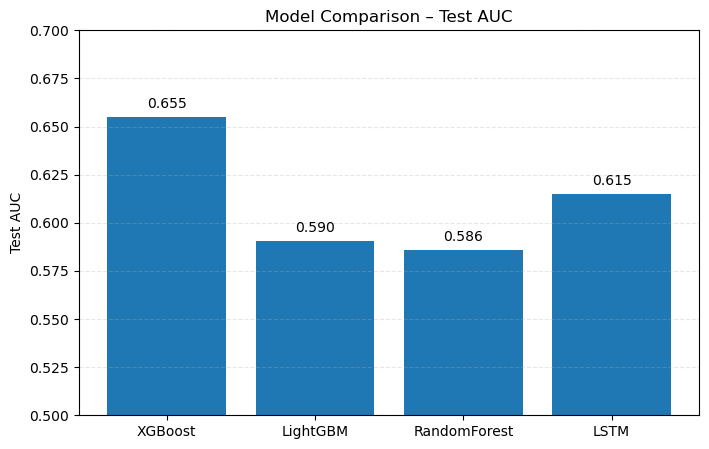

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.bar(combined["Model"], combined["Test AUC"])
plt.ylabel("Test AUC")
plt.title("Model Comparison – Test AUC")
plt.ylim(0.5, 0.7)
for i, v in enumerate(combined["Test AUC"]):
    plt.text(i, v + 0.005, f"{v:.3f}", ha="center")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


In [5]:
import sys, os

os.chdir("/Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter")
print("CWD:", os.getcwd())

!"{sys.executable}" scripts/LSTM.py


CWD: /Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter
/Users/rosaliemassein/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Epoch 1: train_loss=0.6849  val_AUC=0.4471
Epoch 2: train_loss=0.6675  val_AUC=0.5275
Epoch 3: train_loss=0.6513  val_AUC=0.5647
Epoch 4: train_loss=0.6409  val_AUC=0.5902
Epoch 5: train_loss=0.6254  val_AUC=0.5824
Epoch 6: train_loss=0.6201  val_AUC=0.5882
Epoch 7: train_loss=0.6045  val_AUC=0.5980
Epoch 8: train_loss=0.5970  val_AUC=0.6039
Epoch 9: train_loss=0.5881  val_AUC=0.5922
Epoch 10: train_loss=0.5787  val_AUC=0.5784
Epoch 11: train_loss=0.5665  val_AUC=0.5784
Epoch 12: train_loss=0.5538  val_AUC=0.5745
Epoch 13: trai

In [6]:
!"{sys.executable}" scripts/analyze_models.py


ANALYZING BEST TREE MODELS

[1/7] Loading results from reports/model_comparison_results.csv...
  Best XGBoost: XGB: Technical + Enhanced Sentiment (ALL) (Test AUC: 0.6399)
  Best LightGBM: LGB: Technical + Enhanced Sentiment (ALL) (Test AUC: 0.6515)
  Best Random Forest: RF: Technical + Enhanced Sentiment (ALL) (Test AUC: 0.5437)

[2/7] Loading data...
  Using 94 features (46 technical + 48 sentiment MA)

[3/7] Splitting data...
  Train: 186, Val: 52, Test: 62

[4/7] Training best models...
  Training XGBoost...
  Training LightGBM...
  Training Random Forest...

[5/7] Evaluating models...
  XGBoost: Test AUC = 0.6548, Acc = 0.5968
  LightGBM: Test AUC = 0.5905, Acc = 0.5323
  RandomForest: Test AUC = 0.5857, Acc = 0.5645
  Saved XGBoost to models/best_xgboost.pkl
  Saved LightGBM to models/best_lightgbm.pkl
  Saved RandomForest to models/best_randomforest.pkl

[6/7] Generating analysis outputs...
  [1/4] Saved metrics table
[info] Added LSTM ROC curve (AUC=0.6027)
[info] Saved ROC cur

In [17]:
import os, sys

os.chdir("/Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter")
print("CWD:", os.getcwd())

# 1) Train & tune LSTM (this will write reports/lstm_results.csv + lstm_test_predictions.csv)
!"{sys.executable}" scripts/LSTM_copy.py

# 2) Re-run model analysis (trees + tuned LSTM)
!"{sys.executable}" scripts/analyze_models.py


CWD: /Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter
[info] Using device: cpu

[1/4] Loading & preparing data...
[info] #tech features       : 12
[info] #sentiment MA feats : 48
[info] #TOTAL LSTM features: 60
[info] Train dates: 2025-08-12 → 2025-10-06 (n=186)
[info] Val   dates: 2025-10-07 → 2025-10-16 (n=52)
[info] Test  dates: 2025-10-17 → 2025-10-29 (n=62)

[2/4] Running LSTM hyperparameter sweep...

--- LSTM config: seq_len=3, hidden=32, dropout=0.0, lr=0.001 ---
Epoch 01: train_loss=0.7008  val_ACC=0.4800  val_AUC=0.4800
Epoch 02: train_loss=0.6877  val_ACC=0.5600  val_AUC=0.5600
Epoch 03: train_loss=0.6781  val_ACC=0.8000  val_AUC=0.5800
Epoch 04: train_loss=0.6686  val_ACC=0.8400  val_AUC=0.6600
Epoch 05: train_loss=0.6595  val_ACC=0.7600  val_AUC=0.6800
Epoch 06: train_loss=0.6508  val_ACC=0.7600  val_AUC=0.6700
Epoch 07: train_loss=0.6440  val_ACC=0.7600  val_AUC=0.6600
Epoch 08: train_loss=0.6343  v

/Users/rosaliemassein/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
Epoch 26: train_loss=0.5226  val_ACC=0.0000  val_AUC=nan
/Users/rosaliemassein/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
Epoch 27: train_loss=0.5101  val_ACC=0.0000  val_AUC=nan
/Users/rosaliemassein/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
Epoch 28: train_loss=0.5060  val_ACC=1.0000  val_AUC=nan
/Users/rosaliemassein/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one c

In [18]:
import os, sys

os.chdir("/Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter")
print("CWD:", os.getcwd())

# 1) Train & tune LSTM (this will write reports/lstm_results.csv + lstm_test_predictions.csv)
!"{sys.executable}" scripts/LSTM_copy.py

# 2) Re-run model analysis (trees + tuned LSTM)
!"{sys.executable}" scripts/analyze_models.py

CWD: /Users/rosaliemassein/Documents/stanford/Autumn 2025/CS229/Project/ML-Stock-Prediction-main/cs229-sentiment-vs-tech-starter
/Users/rosaliemassein/opt/anaconda3/envs/cs229/lib/python3.9/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Epoch 1: train_loss=0.6856  val_AUC=0.4706
Epoch 2: train_loss=0.6671  val_AUC=0.5353
Epoch 3: train_loss=0.6525  val_AUC=0.6118
Epoch 4: train_loss=0.6415  val_AUC=0.6569
Epoch 5: train_loss=0.6279  val_AUC=0.6569
Epoch 6: train_loss=0.6203  val_AUC=0.6431
Epoch 7: train_loss=0.6091  val_AUC=0.6314
Epoch 8: train_loss=0.5980  val_AUC=0.6216
Epoch 9: train_loss=0.5859  val_AUC=0.6196
Epoch 10: train_loss=0.5769  val_AUC=0.6000
Epoch 11: train_loss=0.5620  val_AUC=0.5843
Epoch 12: train_loss=0.5535  val_AUC=0.5804
Epoch 13: trai